### 导入所需要的包

In [1]:
import sys
import os

# 添加 src 到路径, 便于导入
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "../src")))

%matplotlib widget
import matplotlib.pyplot as plt

import json

from shapely.geometry import Point, Polygon, LineString, box
import math
import numpy as np
import re
from rich import print

# 自定义模块导入
from display_class import *
from CADAlgo.check import *
from CADAlgo.generate import *
from CADAlgo.parser import *

In [2]:
def test_from_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        final_result_dict = json.load(f)
    schema = parse_schema(final_result_dict)
    _, _ = plot_schema(schema)
    line_candidate: list[LineString] = []
    for my_line in schema.line_candidates[:]:
        for l in my_line.lines:
            line_candidate.append(l.geometry)

    point_candidates = schema.point_candidates
    line_candidates = schema.line_candidates
    exterior = schema.target_exterior
    obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
    samples_distance = 3
    lines = generate_connection_lines_from_point_candidates_backtracking(
        point_candidates, line_candidates, exterior, obstacles,dispel_lines=[], samples_distance=samples_distance
    )

    fig, ax = plot_schema(schema)

    # 连接线
    for line in lines:
        x_line, y_line = line.xy
        ax.plot(x_line, y_line, color="magenta", linewidth=1.5)

    print(f"Total parts: {len(schema.point_candidates)+len(schema.line_candidates)}")
    return schema

下面是带优先级的效果

Total parts: 25

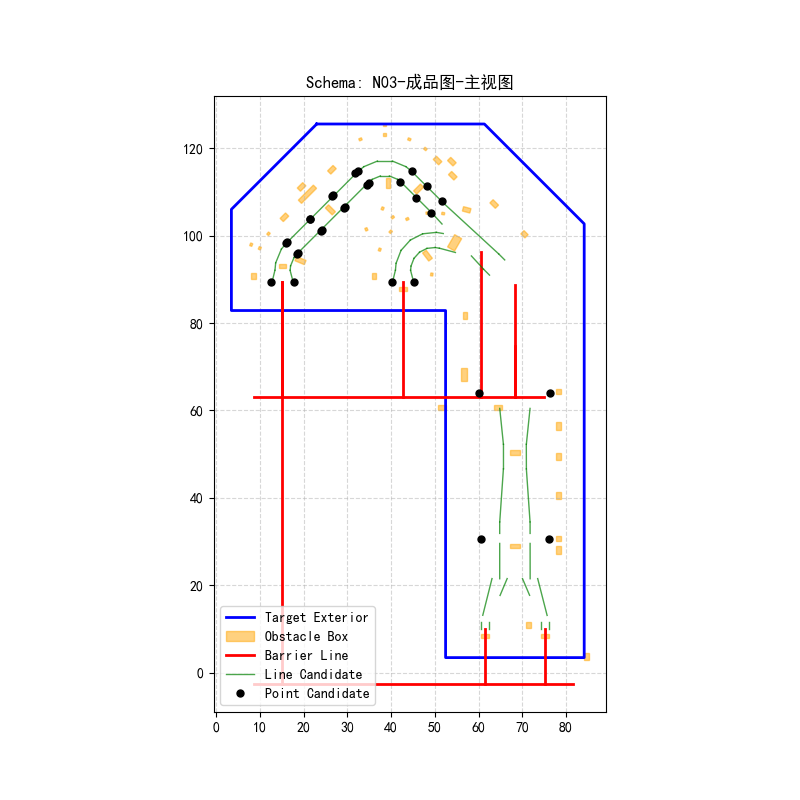

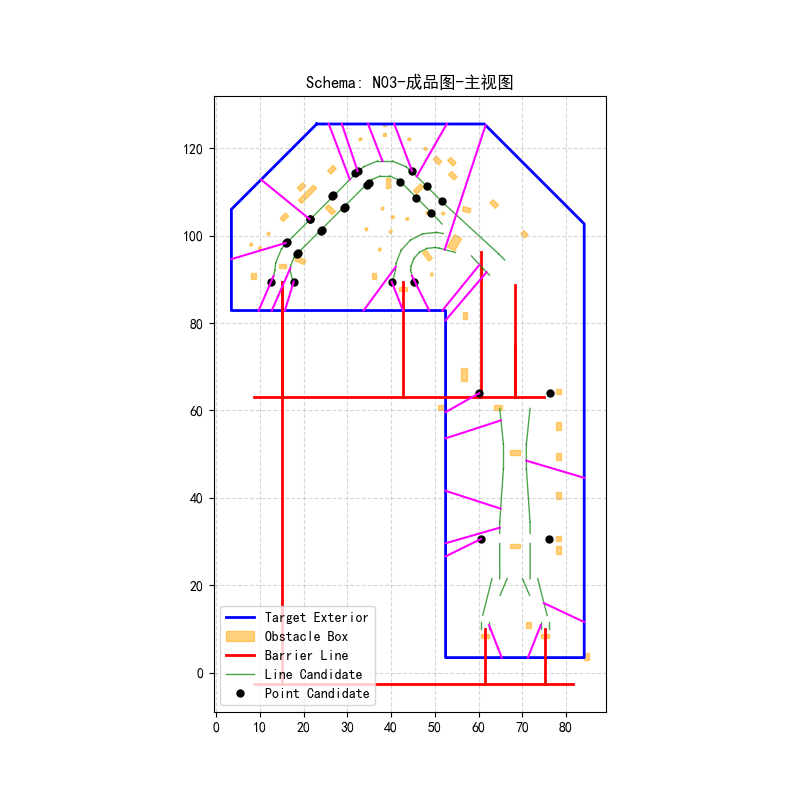

In [3]:
schema = test_from_json(os.path.join("real_data", "N03-成品图-主视图_schema.json"))

Total parts: 12

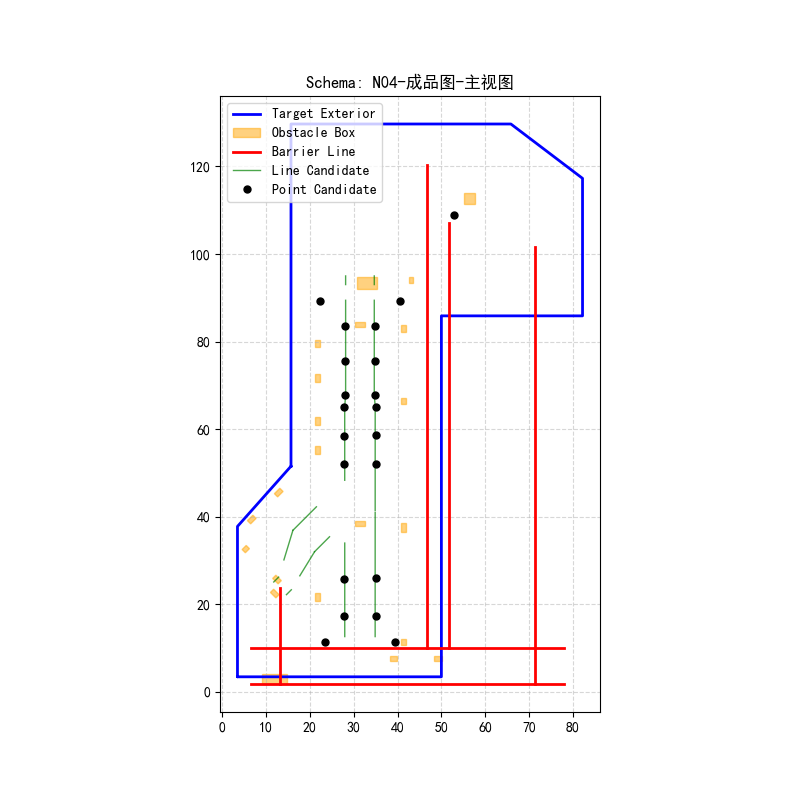

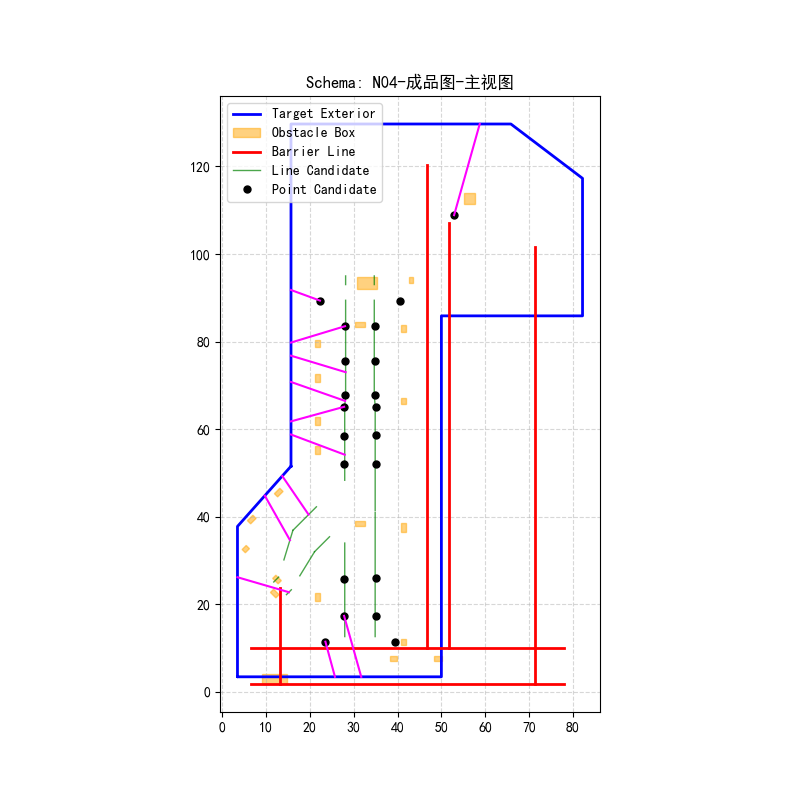

In [4]:
test_from_json(os.path.join("real_data", "N04-成品图-主视图_schema.json"))

Total parts: 5

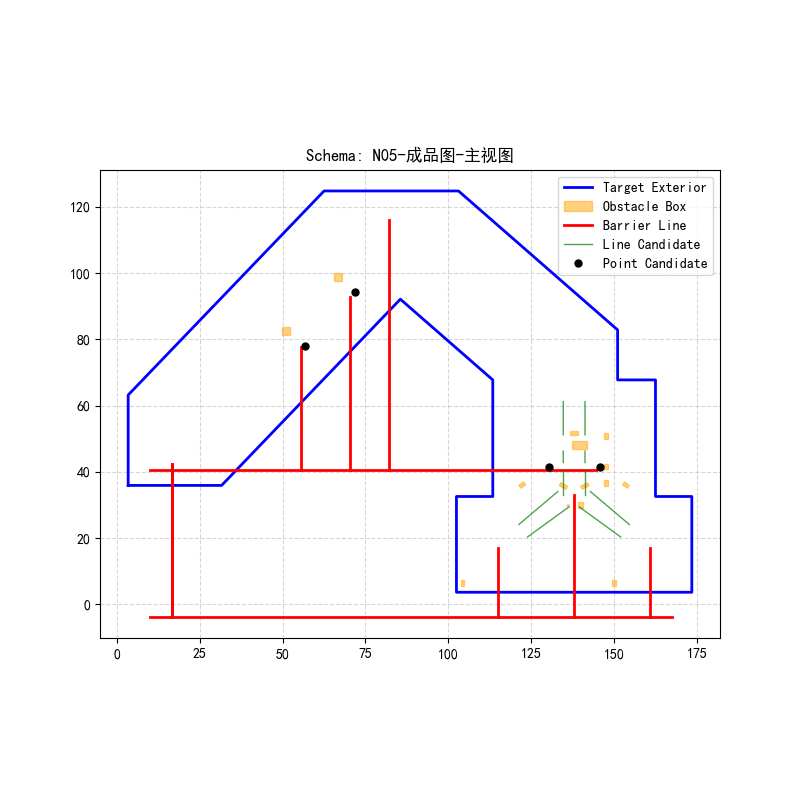

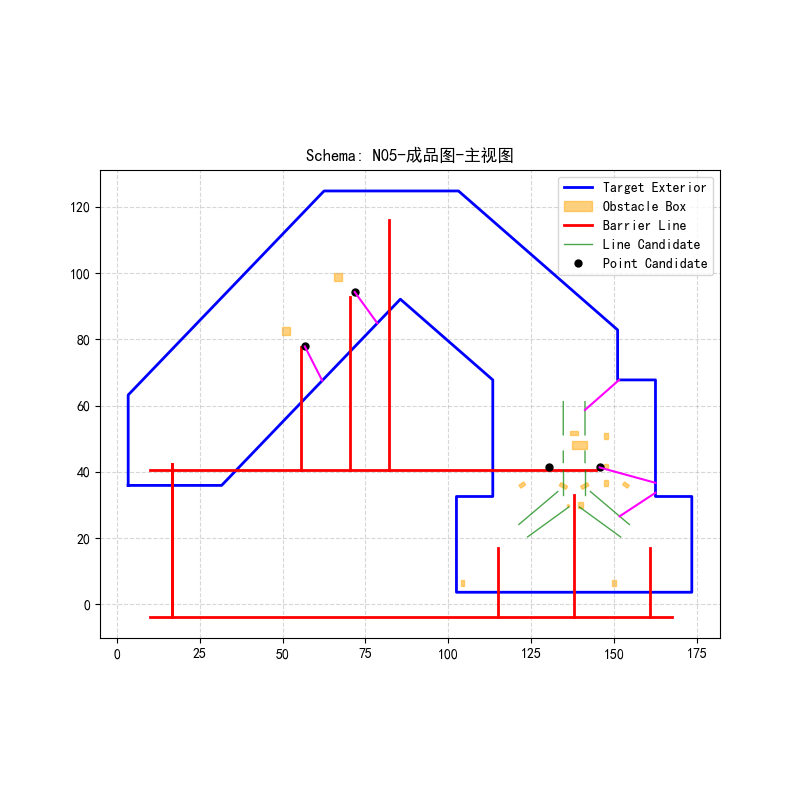

In [5]:
test_from_json(os.path.join("real_data", "N05-成品图-主视图_schema.json"))

Total parts: 2

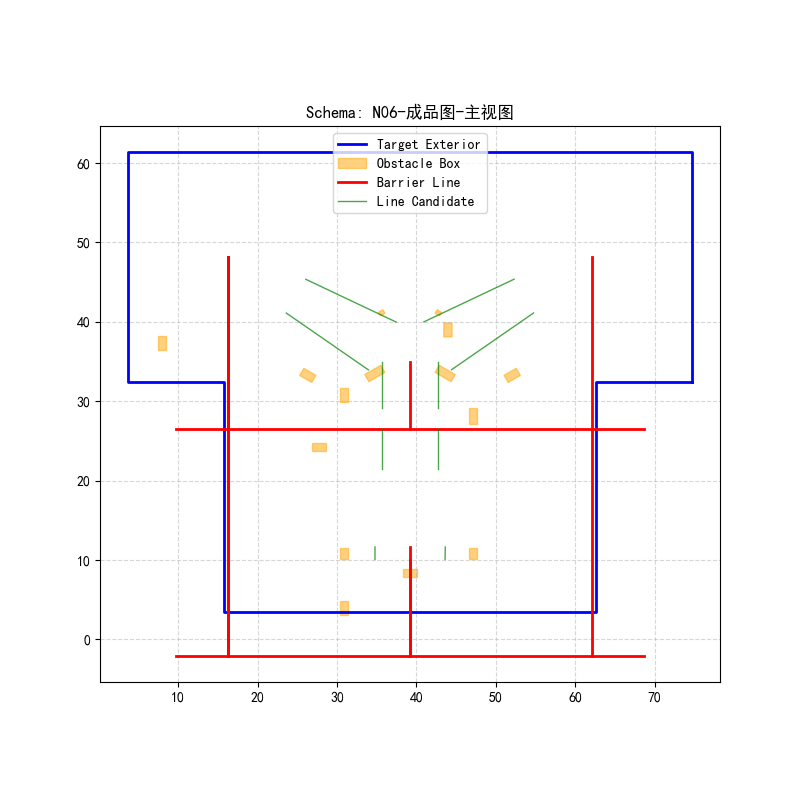

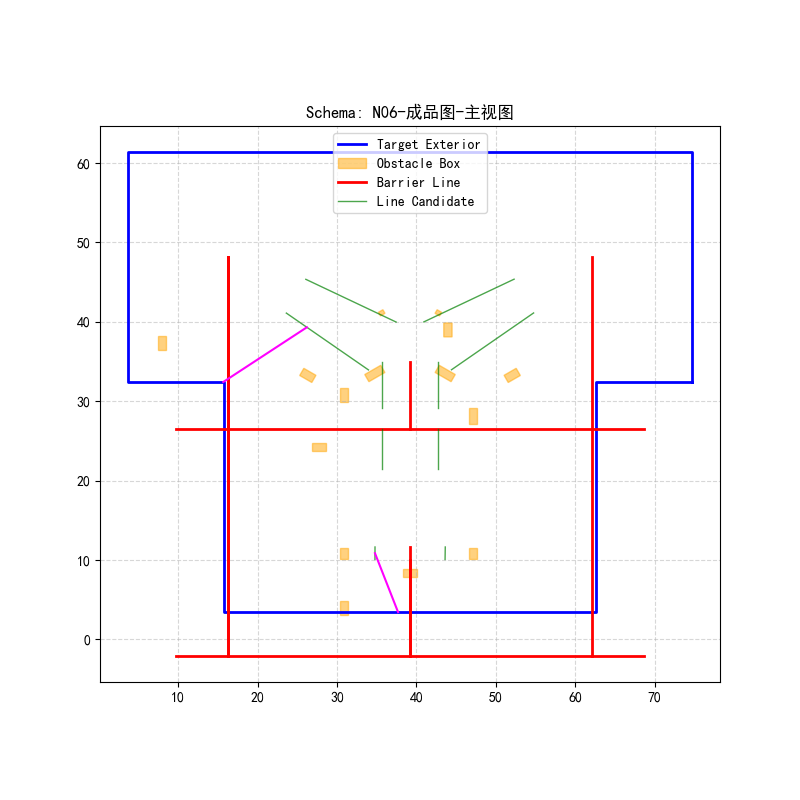

In [6]:
test_from_json(os.path.join("real_data", "N06-成品图-主视图_schema.json"))

Total parts: 14

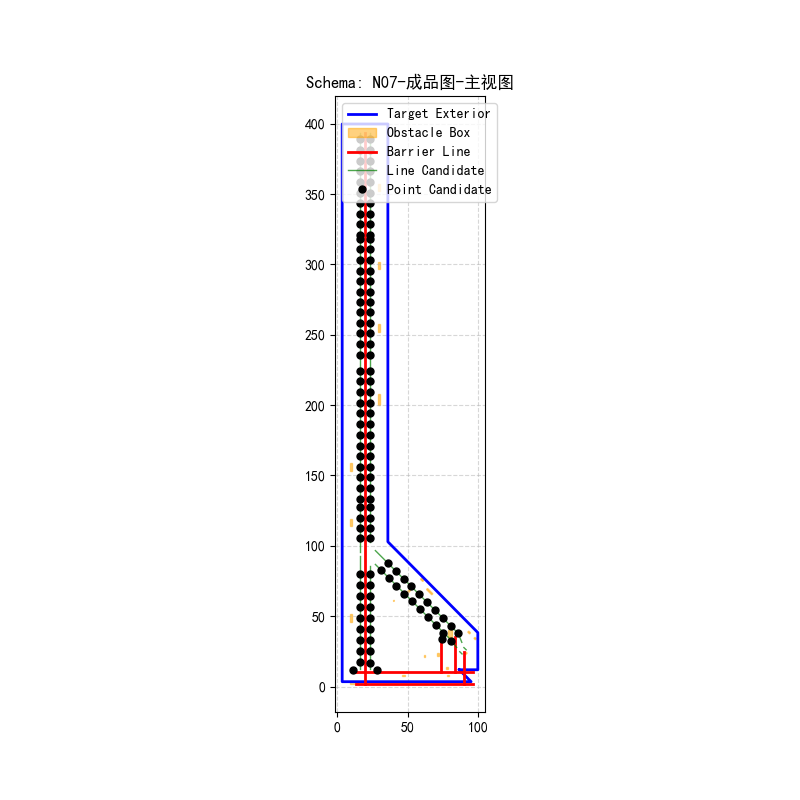

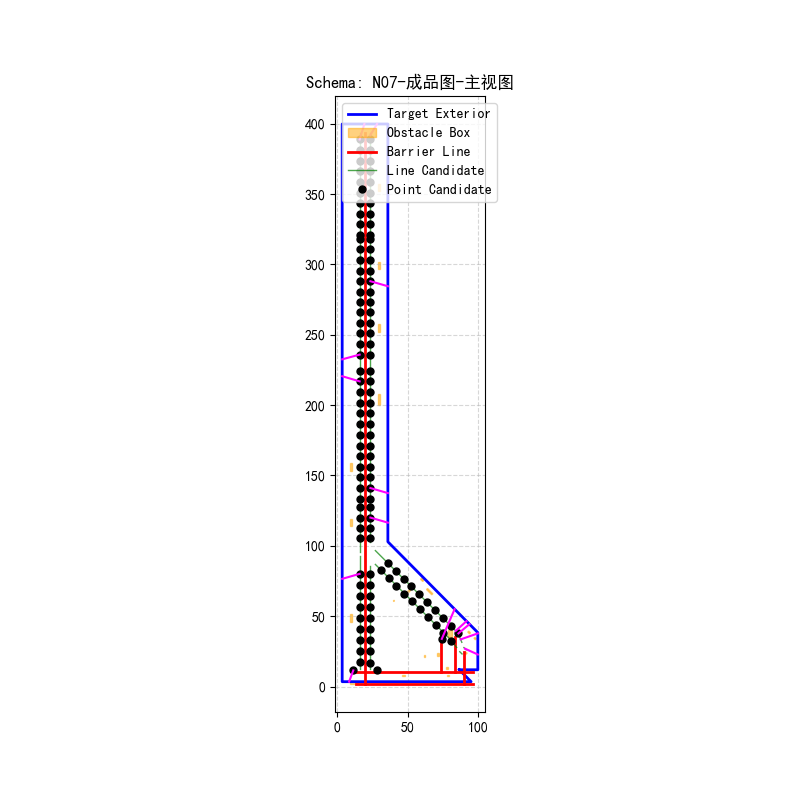

In [7]:
test_from_json(os.path.join("real_data", "N07-成品图-主视图_schema.json"))

Total parts: 10

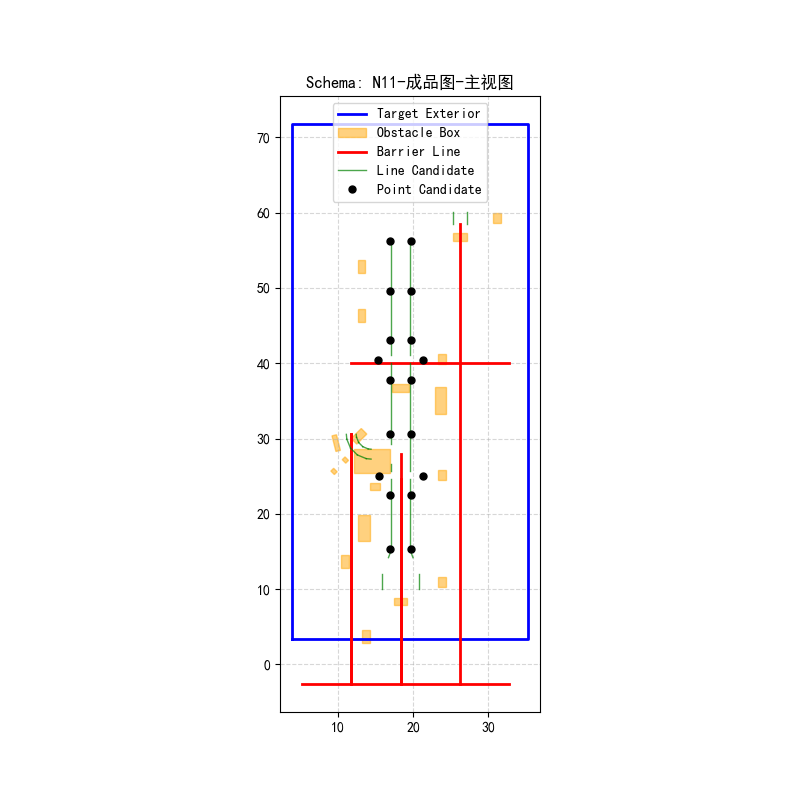

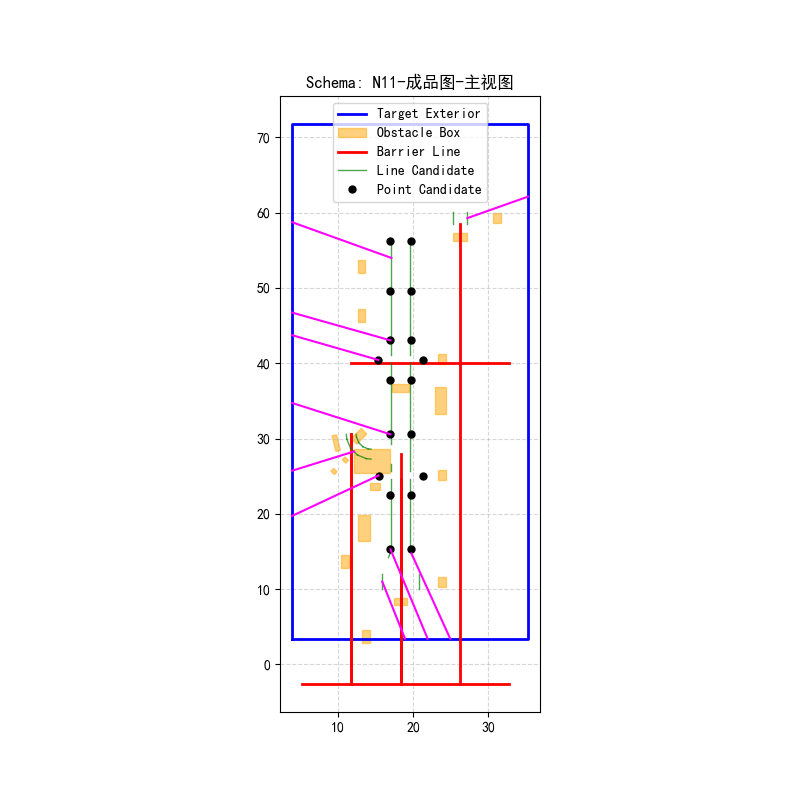

In [8]:
test_from_json(os.path.join("real_data", "N11-成品图-主视图_schema.json"))

Total parts: 7

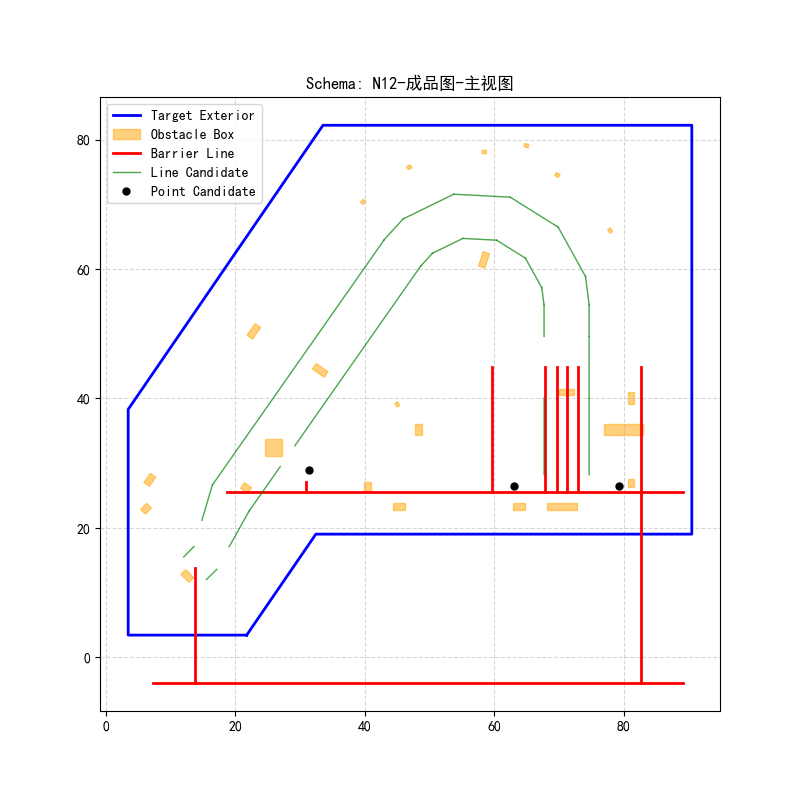

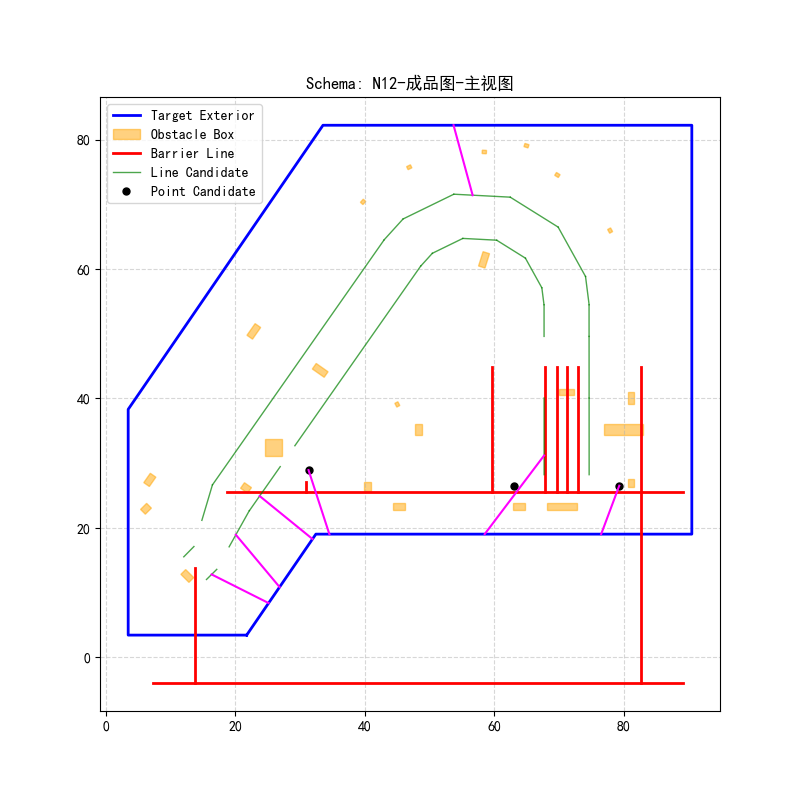

In [9]:
test_from_json(os.path.join("real_data", "N12-成品图-主视图_schema.json"))

(<Figure size 800x600 with 1 Axes>, <Axes: >)

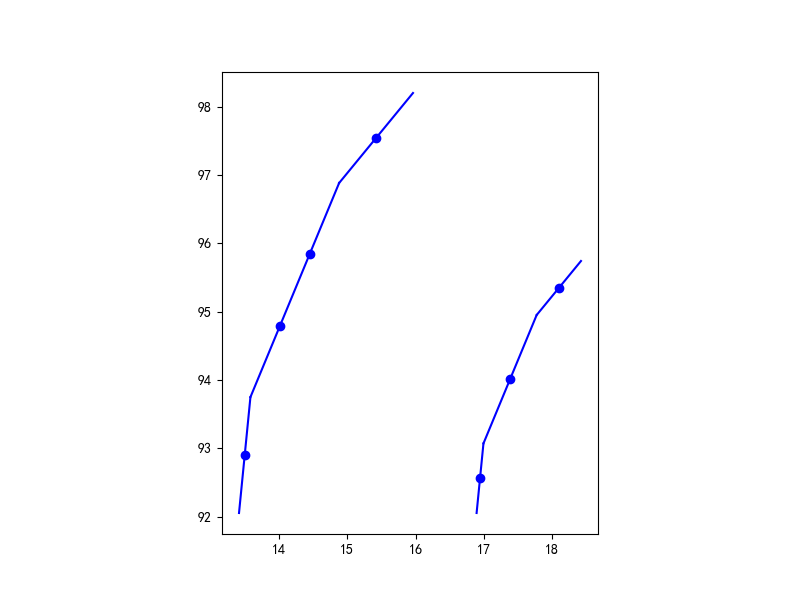

In [10]:
geometries = []
for line_candidate in schema.line_candidates:
    if line_candidate.part_id in [5285428, "5285432", "5285590"]:
        for line in line_candidate.lines:
            geometries.append(line.geometry)
        for point_candidate in line_candidate.to_point_candidate_v2().points:
            geometries.append(point_candidate.geometry)
plot_geometries(geometries)

假设有：
- 一系列矩形(`Polygon`)。
- 一条或多条直线(`LineString`)。

想找出哪些矩形与直线相交。直接循环所有矩形会慢，**STRtree 可以加速**：

1. 把矩形构建成 **STRtree** 索引。
2. 对每条直线调用 `query`，只返回可能相交的矩形。
3. 再用 `.intersects()` 精确判断实际相交的矩形。

查询到的可能碰撞矩形数量: 40

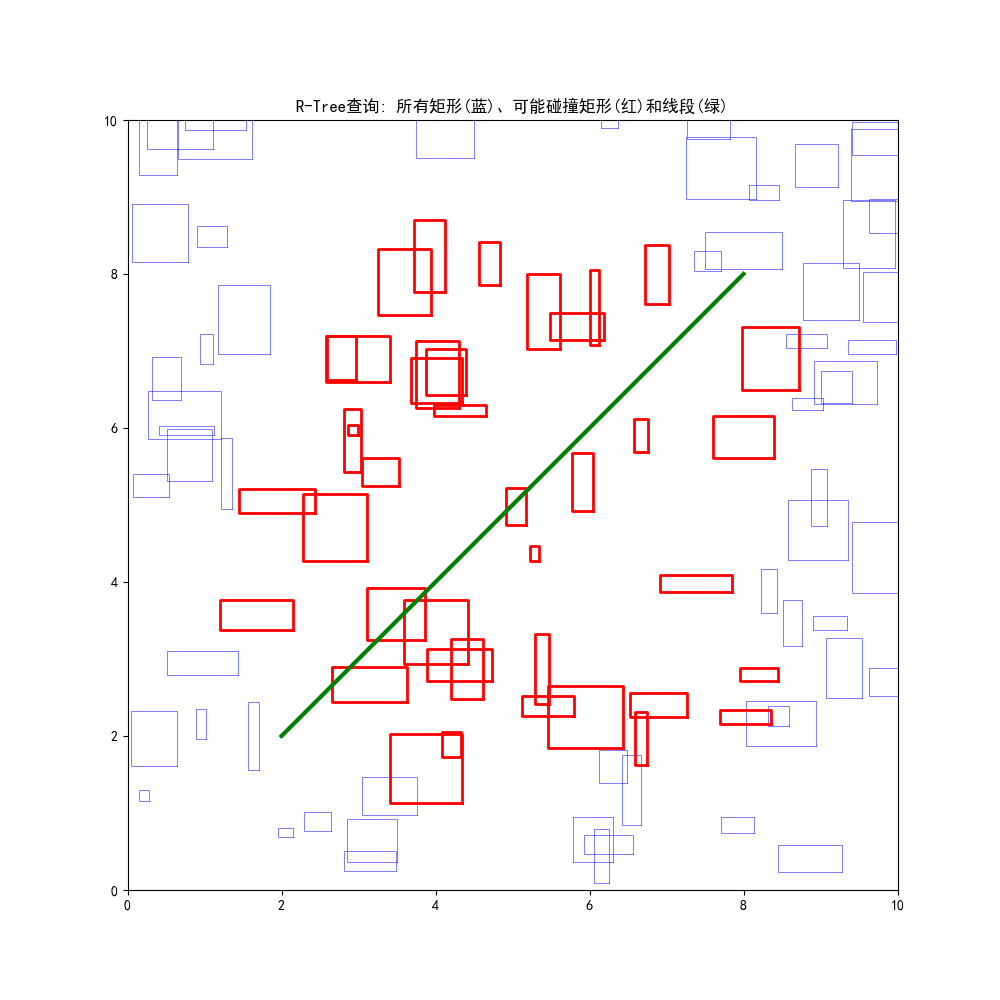

In [11]:
import numpy as np
from shapely.geometry import box, LineString
from shapely import STRtree
import matplotlib.pyplot as plt

# 生成100个随机矩形(在[0,10]x[0,10]区域内)
np.random.seed(42)  # 为可重复性设置种子
n_rects = 100
rects = []
for _ in range(n_rects):
    x = np.random.uniform(0, 10)
    y = np.random.uniform(0, 10)
    w = np.random.uniform(0.1, 1)
    h = np.random.uniform(0.1, 1)
    rects.append(box(x, y, x + w, y + h))

# 创建STRtree(Shapely的R-Tree实现)
index = STRtree(rects)

# 创建一条示例线段
line = LineString([(2, 2), (8, 8)])

# 查询与线段可能碰撞(相交)的矩形，返回的是索引
hit_indices = index.query(line)
# 根据索引获取实际的矩形几何对象
hits = [rects[i] for i in hit_indices]
print(f"查询到的可能碰撞矩形数量: {len(hits)}")

# 可视化
fig, ax = plt.subplots(figsize=(10, 10))
# 绘制所有矩形(蓝色，细线)
for rect in rects:
    x, y = rect.exterior.xy
    ax.plot(x, y, 'b-', linewidth=0.5, alpha=0.7)

# 绘制可能碰撞的矩形(红色，粗线)
for hit in hits:
    x, y = hit.exterior.xy
    ax.plot(x, y, 'r-', linewidth=2)

# 绘制线段(绿色，粗线)
line_x, line_y = line.xy
ax.plot(line_x, line_y, 'g-', linewidth=3)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.set_title('R-Tree查询: 所有矩形(蓝)、可能碰撞矩形(红)和线段(绿)')
plt.show()